In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Style sheet
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath}",
        "mathtext.fontset": "cm",
        "font.family": "cmu serif",
        "font.size": 12,
        "lines.linewidth": 2,
    }
)

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]


## Import data, setup 

In [7]:
from data.simulated_data.generate_simulated_data import generate_simulated_data
from src.algorithms import IMMCV, RGPMT_ND, MMRGP
from src.utils import sq_exp_kernel, matern_kernel

generate_simulated_data(meas_drop_rate=0.9, seed=42)
data = np.load("./data/simulated_data/data.npz")

time_steps = data["time"]
true_x = data["true_x"]
true_y = data["true_y"]
meas_x = data["meas_x"][0]
meas_y = data["meas_y"][0]
mask = data["mask"][0]


num_time_steps = len(time_steps)
num_measurements = np.sum(mask)
q_levels = np.array([1.0, 5.0, 10.0, 15.0, 20.0]) * 1e-2
length_scales = np.array([1.0, 3.0, 5.0, 7.0, 9.0])
r = 0.5
num_models = len(q_levels)
num_states = 25
kernel = sq_exp_kernel
theta_init = np.array([5.0, 5.0, 0.5])

imm_cv = IMMCV(q_levels, r, time_steps[1] - time_steps[0])
rgp_mt = RGPMT_ND(num_states, time_steps[0:num_states], [meas_x[0:num_states], meas_y[0:num_states]], kernel, theta_init=theta_init)
mm_rgp = MMRGP(kernel, time_steps[-1], length_scales, r, num_states, 1e-3, 5.0)

print("Number of timesteps:", num_time_steps)
print("Number of observations:", num_measurements)

Number of timesteps: 1500
Number of observations: 155


## IMM-CV single run

IMM-CV total run time: 0.21 seconds for 1500 steps.
Average runtime for IMM-CV: 3.876425e-04 seconds


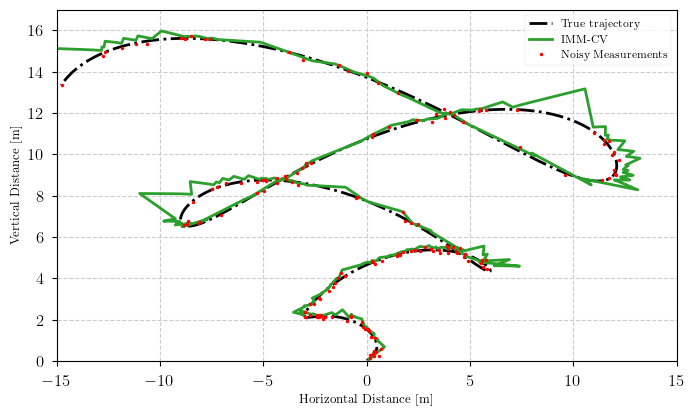

In [8]:
est_x = np.zeros(num_time_steps)
est_y = np.zeros(num_time_steps)
mode_probs = np.zeros((num_time_steps, num_models))

start = time.time()
time_list = []
for k in range(num_time_steps):
    start_time = time.time()
    z = np.array([meas_x[k], meas_y[k]])
    imm_cv.predict()
    if not np.isnan(z).any():
        imm_cv.update(z)
        delta_time = time.time() - start_time
        # print("{:e}".format(delta_time))
        time_list.append(delta_time)

    # Save estimates
    est_x[k] = imm_cv.x[0][0]
    est_y[k] = imm_cv.x[2][0]
    mode_probs[k] = imm_cv.mu

print(f"IMM-CV total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for IMM-CV: {:e} seconds".format(np.mean(time_list)))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true_x, true_y, "k-.", label="True trajectory")
ax.plot(est_x, est_y, label="IMM-CV", color=colors[2])
ax.plot(
    meas_x,
    meas_y,
    linestyle="",
    marker=".",
    color="red",
    label="Noisy Measurements",
    markersize=5,
)
ax.set_aspect("equal")
ax.set_xlabel("Horizontal Distance [m]")
ax.set_ylabel("Vertical Distance [m]")
ax.legend()
ax.set_ylim((0.0, 17.0))
ax.set_xlim((-15.0, 15.0))
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./figures/simulation/imm_cv.pdf", format="pdf", bbox_inches="tight")

## RGPMT single run

RGP*MT total run time: 16.44 seconds for 1500 steps.
Average runtime for RGP*MT: 1.197752e-02 seconds.


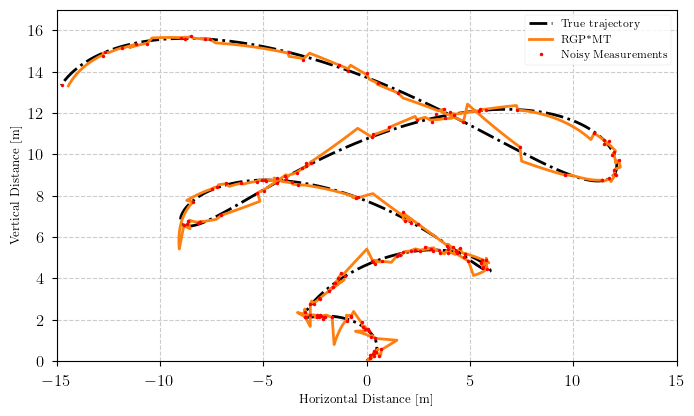

In [9]:
start = time.time()
time_list = []
for k in range(num_time_steps):
    start_time = time.time()
    z = np.array([meas_x[k], meas_y[k]])
    meas_time = time_steps[k]
    rgp_mt.step(z, meas_time)
    if not np.isnan(z).any():
        delta_time = time.time() - start_time
        # print("{:e}".format(delta_time))
        time_list.append(delta_time)

print(f"RGP*MT total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for RGP*MT: {:e} seconds.".format(np.mean(time_list)))

est_traj = rgp_mt.predicted_mean()
est_x = est_traj[0]
est_y = est_traj[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true_x, true_y, "k-.", label="True trajectory")
ax.plot(est_x, est_y, label="RGP*MT", color=colors[1])
ax.plot(
    meas_x,
    meas_y,
    linestyle="",
    marker=".",
    color="red",
    label="Noisy Measurements",
    markersize=5,
)
ax.set_aspect("equal")
ax.set_xlabel("Horizontal Distance [m]")
ax.set_ylabel("Vertical Distance [m]")
ax.legend()
ax.set_ylim((0.0, 17.0))
ax.set_xlim((-15.0, 15.0))
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./figures/simulation/rgpmt.pdf", format="pdf", bbox_inches="tight")

## MM-RGP single run

IMM-RGP total run time: 0.71 seconds for 1500 steps.
Average runtime for IMM-RGP: 1.219074e-03 seconds


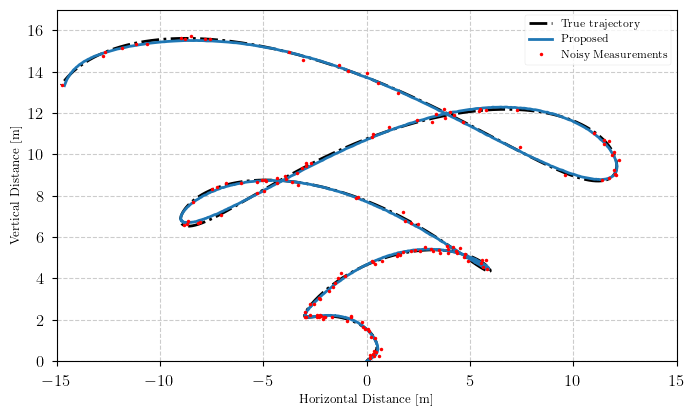

In [10]:
start = time.time()
time_list = []
for k in range(num_time_steps):
    start_time = time.time()
    z = np.array([meas_x[k], meas_y[k]])
    meas_time = time_steps[k]
    mm_rgp.time_update()
    if not np.isnan(z).any():
        mm_rgp.meas_update(z, meas_time)
        delta_time = time.time() - start_time
        time_list.append(delta_time)

print(f"IMM-RGP total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for IMM-RGP: {:e} seconds".format(np.mean(time_list)))

est_traj = mm_rgp.predicted_mean(time_steps)
est_x = est_traj[0:num_time_steps]
est_y = est_traj[num_time_steps:]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true_x, true_y, "k-.", label="True trajectory")
ax.plot(est_x, est_y, label="Proposed", color=colors[0])
ax.plot(
    meas_x,
    meas_y,
    linestyle="",
    marker=".",
    color="red",
    label="Noisy Measurements",
    markersize=5,
)
ax.set_aspect("equal")
ax.set_xlabel("Horizontal Distance [m]")
ax.set_ylabel("Vertical Distance [m]")
ax.legend()
ax.set_ylim((0.0, 17.0))
ax.set_xlim((-15.0, 15.0))
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./figures/simulation/mm_rgp.pdf", format="pdf", bbox_inches="tight")